# Import general libraries

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Import ML libraries

Install fbprophet model

In [ ]:
!pip install pystan

Import prophet libraries

In [ ]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

Import ML models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from datetime import datetime

# Import dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/item_forecast.csv')
df.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [ ]:
def basic_eda(df):
  print("######## Shape ########")
  print(df.shape)
  print("######## types ########")
  print(df.dtypes)
  print("######## head #########")
  print(df.head())
  print("######## tail #########")
  print(df.tail())
  print("######## isnull ########")
  print(df.isnull().sum())

basic_eda(df)

######## Shape ########
(913000, 4)
######## types ########
date     object
store     int64
item      int64
sales     int64
dtype: object
######## head #########
         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
######## tail #########
              date  store  item  sales
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82
######## isnull ########
date     0
store    0
item     0
sales    0
dtype: int64


In [ ]:
# Convert sales to type float
df['sales'] = df['sales'].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    913000 non-null  object 
 1   store   913000 non-null  int64  
 2   item    913000 non-null  int64  
 3   sales   913000 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.9+ MB


In [ ]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [ ]:
print('No of stores:',df['store'].nunique())
print('No of items:',df['item'].nunique())

No of stores: 10
No of items: 50


In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales           float64
dtype: object

In [ ]:
df1 = pd.pivot_table(df, values = "sales", index="date", columns = "item", aggfunc = np.sum)
df1

item           1      2      3      4      5      6      7      8      9   \
date                                                                        
2013-01-01  133.0  327.0  172.0  102.0   83.0  288.0  278.0  416.0  245.0   
2013-01-02   99.0  279.0  213.0  110.0   81.0  310.0  291.0  386.0  225.0   
2013-01-03  127.0  304.0  193.0  112.0   96.0  309.0  324.0  398.0  265.0   
2013-01-04  145.0  359.0  218.0  138.0  108.0  343.0  335.0  430.0  313.0   
2013-01-05  149.0  377.0  217.0  144.0  100.0  343.0  377.0  481.0  319.0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2017-12-27  154.0  500.0  282.0  172.0  148.0  406.0  457.0  579.0  387.0   
2017-12-28  178.0  495.0  298.0  190.0  157.0  506.0  499.0  644.0  420.0   
2017-12-29  207.0  515.0  332.0  192.0  177.0  530.0  532.0  648.0  494.0   
2017-12-30  236.0  538.0  342.0  211.0  173.0  532.0  609.0  784.0  492.0   
2017-12-31  227.0  634.0  402.0  228.0  188.0  565.0  610.0  823.0  544.0   

item           10  ...     41     42     43     44     45     46     47  \
date               ...                                                    
2013-01-01  378.0  ...  103.0  195.0  253.0  154.0  396.0  319.0  116.0   
2013-01-02  397.0  ...  132.0  215.0  255.0  165.0  393.0  316.0  118.0   
2013-01-03  388.0  ...  131.0  215.0  306.0  170.0  459.0  325.0  104.0   
2013-01-04  462.0  ...  122.0  224.0  323.0  189.0  450.0  351.0  128.0   
2013-01-05  449.0  ...  142.0  243.0  309.0  202.0  533.0  360.0  133.0   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2017-12-27  546.0  ...  176.0  264.0  381.0  233.0  681.0  487.0  171.0   
2017-12-28  609.0  ...  172.0  346.0  415.0  248.0  707.0  473.0  188.0   
2017-12-29  617.0  ...  185.0  304.0  457.0  277.0  724.0  548.0  213.0   
2017-12-30  698.0  ...  177.0  338.0  507.0  266.0  762.0  566.0  190.0   
2017-12-31  721.0  ...  246.0  364.0  487.0  299.0  805.0  605.0  211.0   

item           48     49     50  
date                             
2013-01-01  277.0  159.0  330.0  
2013-01-02  281.0  159.0  384.0  
2013-01-03  280.0  187.0  356.0  
2013-01-04  296.0  184.0  394.0  
2013-01-05  344.0  179.0  407.0  
...           ...    ...    ...  
2017-12-27  374.0  231.0  511.0  
2017-12-28  395.0  276.0  587.0  
2017-12-29  496.0  237.0  596.0  
2017-12-30  502.0  303.0  612.0  
2017-12-31  494.0  285.0  626.0  

[1826 rows x 50 columns]

In [ ]:
df_date_item = df.groupby(["date","item"])["sales"].sum().reset_index()
df_date_item

date  item  sales
0     2013-01-01     1  133.0
1     2013-01-01     2  327.0
2     2013-01-01     3  172.0
3     2013-01-01     4  102.0
4     2013-01-01     5   83.0
...          ...   ...    ...
91295 2017-12-31    46  605.0
91296 2017-12-31    47  211.0
91297 2017-12-31    48  494.0
91298 2017-12-31    49  285.0
91299 2017-12-31    50  626.0

[91300 rows x 3 columns]

In [ ]:
fig = px.line(df_date_item, x='date', y='sales')
fig.show()

# Rolling mean of 90 day sales

In [ ]:
df_date_item['moving_average'] = df_date_item['sales'].rolling(window = 90).sum().shift(-89)

In [ ]:
fig = px.line(df_date_item, x='date', y='moving_average')
fig.show()

In [ ]:
# Replace column names and convert to dataframe

df1.columns = [ 'item_' + str(i) for i in range(1,len(df1.columns)+1)]
df1 = df1.reset_index()
df1

date  item_1  item_2  item_3  item_4  item_5  item_6  item_7  \
0    2013-01-01   133.0   327.0   172.0   102.0    83.0   288.0   278.0   
1    2013-01-02    99.0   279.0   213.0   110.0    81.0   310.0   291.0   
2    2013-01-03   127.0   304.0   193.0   112.0    96.0   309.0   324.0   
3    2013-01-04   145.0   359.0   218.0   138.0   108.0   343.0   335.0   
4    2013-01-05   149.0   377.0   217.0   144.0   100.0   343.0   377.0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
1821 2017-12-27   154.0   500.0   282.0   172.0   148.0   406.0   457.0   
1822 2017-12-28   178.0   495.0   298.0   190.0   157.0   506.0   499.0   
1823 2017-12-29   207.0   515.0   332.0   192.0   177.0   530.0   532.0   
1824 2017-12-30   236.0   538.0   342.0   211.0   173.0   532.0   609.0   
1825 2017-12-31   227.0   634.0   402.0   228.0   188.0   565.0   610.0   

      item_8  item_9  ...  item_41  item_42  item_43  item_44  item_45  \
0      416.0   245.0  ...    103.0    195.0    253.0    154.0    396.0   
1      386.0   225.0  ...    132.0    215.0    255.0    165.0    393.0   
2      398.0   265.0  ...    131.0    215.0    306.0    170.0    459.0   
3      430.0   313.0  ...    122.0    224.0    323.0    189.0    450.0   
4      481.0   319.0  ...    142.0    243.0    309.0    202.0    533.0   
...      ...     ...  ...      ...      ...      ...      ...      ...   
1821   579.0   387.0  ...    176.0    264.0    381.0    233.0    681.0   
1822   644.0   420.0  ...    172.0    346.0    415.0    248.0    707.0   
1823   648.0   494.0  ...    185.0    304.0    457.0    277.0    724.0   
1824   784.0   492.0  ...    177.0    338.0    507.0    266.0    762.0   
1825   823.0   544.0  ...    246.0    364.0    487.0    299.0    805.0   

      item_46  item_47  item_48  item_49  item_50  
0       319.0    116.0    277.0    159.0    330.0  
1       316.0    118.0    281.0    159.0    384.0  
2       325.0    104.0    280.0    187.0    356.0  
3       351.0    128.0    296.0    184.0    394.0  
4       360.0    133.0    344.0    179.0    407.0  
...       ...      ...      ...      ...      ...  
1821    487.0    171.0    374.0    231.0    511.0  
1822    473.0    188.0    395.0    276.0    587.0  
1823    548.0    213.0    496.0    237.0    596.0  
1824    566.0    190.0    502.0    303.0    612.0  
1825    605.0    211.0    494.0    285.0    626.0  

[1826 rows x 51 columns]

Rolling mean graph for all items

In [ ]:
def moving_avg(df1):
  for i in df1.columns[1:6]:
    sales = df1[i].rolling(window=90).sum().shift(-89)
    fig = px.line(df1, x='date', y=sales)
    fig.update_layout(title_text=str(i))
    fig.show()

In [ ]:
moving_avg(df1)

Inference from graphs

# FbProphet model

Let us model for 1 item completely and then apply same procedure to all and provide the metrics for all items.

In [ ]:
def data_prophet(item_number):
  item_data = {"ds": [], "y": []}

  for i in range(len(df1)):
      item_data["ds"] = df1['date']
      item_data["y"] = (df1[item_number].rolling(window=90).sum().shift(-89))
  item_data = pd.DataFrame(item_data)
  item_data.dropna(inplace=True) # Removal of nan values which occured due to moving average
  return item_data

In [ ]:
# Function for fitting the model for training dataset.

def model_fit(item_number):
  #Calling the dataframe for specific item
  item_data = data_prophet(item_number) #Function call - data(item_number)
  train, test = item_data[item_data['ds'] <= '2016-12-31'], item_data[item_data['ds'] > '2016-12-31']
  model = Prophet(interval_width = 0.80, changepoint_range = 0.9, daily_seasonality=True)
  #model = Prophet(changepoint_range=0.9)
  model.fit(train)

  return item_data, train, test, model

In [ ]:
# Model prediction - Main function -> This includes data aggregation function and model fitting function.
def model_prediction_prophet(item_number, periods):
  # Calling model_fit function
  item_data, train, test, model = model_fit(item_number)
  future_dates = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future_dates)
  return item_data, train, test, model, forecast

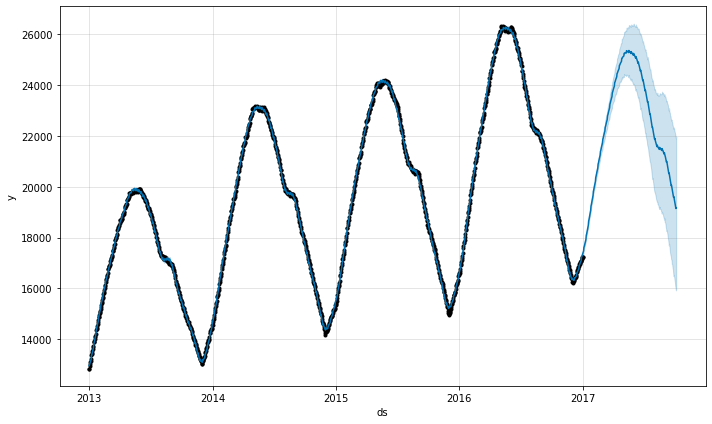

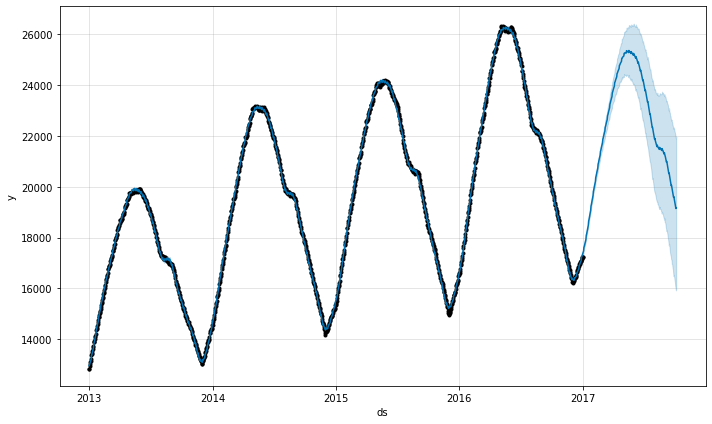

In [ ]:
# Main function call which predicts the data from data aggregation, model fitting to training and predicton
item_data, train, test, model, forecast = model_prediction_prophet('item_1', 276)
model.plot(forecast)

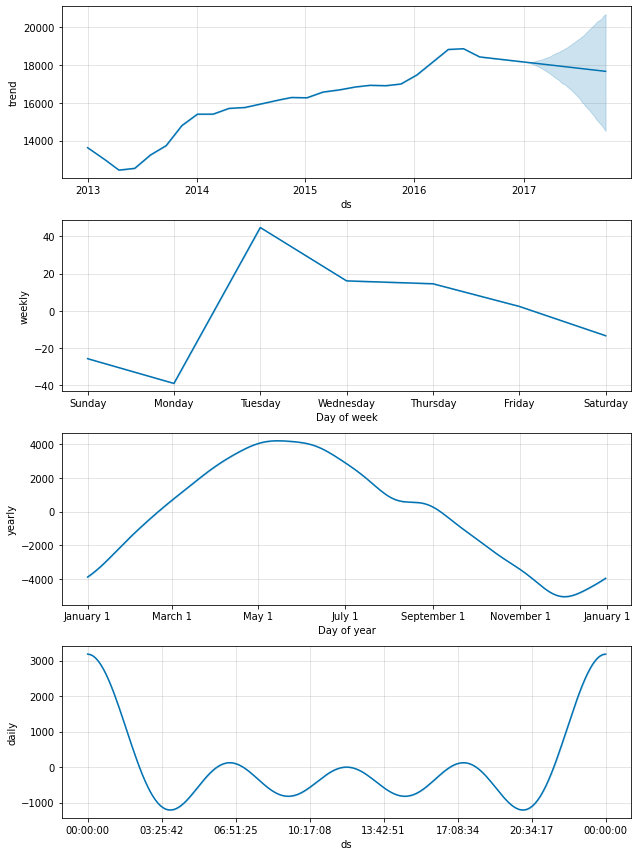

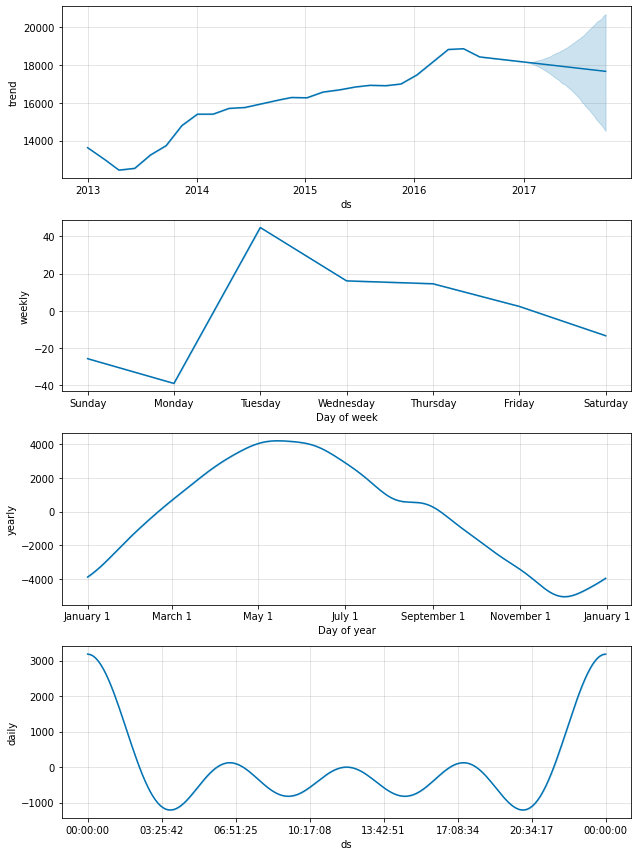

In [ ]:
model.plot_components(forecast)

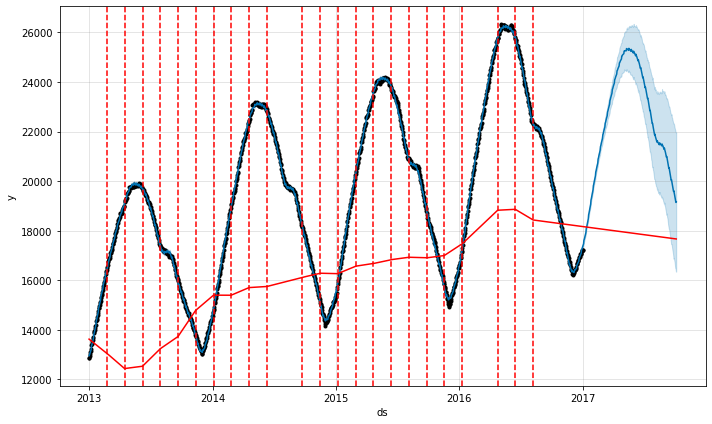

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [ ]:
from fbprophet.plot import plot_plotly
import plotly.offline as py

fig = plot_plotly(model, forecast)
py.iplot(fig)

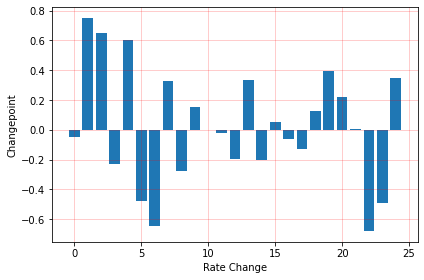

In [ ]:
deltas = model.params['delta'].mean(0)
def plot_changepoint(deltas):
  fig = plt.figure(facecolor = 'w')
  ax = fig.add_subplot(111)
  ax.bar(range(len(deltas)), deltas)
  ax.grid(True, which = 'major', c = 'red', ls = '-', lw = 1, alpha = 0.2)
  ax.set_xlabel('Rate Change')
  ax.set_ylabel('Changepoint')
  fig.tight_layout()

plot_changepoint(deltas)

Lets find the r2 score for item_1 from fbprophet method

In [ ]:
plot_data = {"y_true": [], "y_pred": []}

plot_data['y_true'] = test['y']
plot_data['y_pred'] = forecast[len(train):]['yhat']
plot_data = pd.DataFrame(plot_data)

In [ ]:
fig = px.line(plot_data, x = test['ds'], y = ["y_true", "y_pred"])
fig.update_layout(
    title="Item 1 90_day_sales - forecast prediction - fbProphet", xaxis_title="Date", yaxis_title="Sales"
)
fig.show()

R2 Score

In [ ]:
def r2_metric(test, forecast):
  y_true = test['y']
  y_pred = forecast[len(train):]['yhat']
  r2_metric = r2_score(y_true, y_pred)
  return r2_metric

In [ ]:
r2_metric = r2_metric(test, forecast)
print('The R2 score of 90 day prediction of Item 1 is:', r2_metric)

The R2 score of 90 day prediction of Item 1 is: 0.715124896918109


# ML Models 

From the inference of graph, we found that
1. There is a seasonality monthly trend.
2. There is an yearly trend. The graph indicates the increase of sales year by year.

Based on these analysis, we shall add week, year and also day as additional feature in our model. 

From these features, we shall build the model using Linear Regression, Decision Tree, Random forest and XGBoost. The model is built with default parameters.

Since it a regression problem, we shall compare each model with the R2 score.

In [ ]:
def data_ml(item_number):
  item_data = {"date": [], "90_day_sales": []}

  for i in range(len(df1)):
      item_data["date"] = df1['date']
      item_data["90_day_sales"] = (df1[item_number].rolling(window=90).sum().shift(-89))
  item_data = pd.DataFrame(item_data)
  item_data.dropna(inplace=True) # Removal of nan values which occured due to moving average
  item_data['day']=item_data['date'].dt.day
  item_data['week']=item_data['date'].dt.week
  item_data['year']=item_data['date'].dt.year
  #item_data = item_data.iloc[::7]
  #item_data.set_index('date',inplace=True)
  return item_data

In [ ]:
#df_item1=df_item1.iloc[::7]

Lets model for Item 1 first

In [ ]:
item_data = data_ml('item_1')

Train and test split

In [ ]:
def train_test_split(item_data):
  X_train=item_data[item_data['date'] <= '2016-12-31'].drop(['90_day_sales'],axis=1)
  X_train.set_index('date',inplace=True)
  X_test=item_data[item_data['date'] > '2016-12-31'].drop(['90_day_sales'],axis=1)
  X_test.set_index('date',inplace=True)
  Y_train=item_data['90_day_sales'].iloc[0:len(X_train)]
  Y_test=item_data['90_day_sales'].iloc[len(X_train):]#making train and test datasets
  return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = train_test_split(item_data)

In [ ]:
def predict_plot(model,title):
  model.fit(X_train,Y_train)
  pred=model.predict(X_test)
  yt = Y_test.to_frame()
  yt['prediction'] = pred
  yt['date'] = test['ds']
  r2_metric = r2_score(Y_test, pred)
  fig = px.line(yt, x='date', y=['90_day_sales', 'prediction'], title = title)
  fig.update_layout(
  autosize=False,
  width=600,
  height=300,)

  return r2_metric, fig

In [ ]:
import xgboost as xgb
xgb=xgb.XGBRegressor()
r2_metric_lr, fig_lr = predict_plot(LinearRegression(),'LinearRegression')
r2_metric_dt, fig_dt = predict_plot(DecisionTreeRegressor(),'DecisionTree')
r2_metric_rf, fig_rf = predict_plot(RandomForestRegressor(),'RandomForest')
r2_metric_xgb, fig_xgb = predict_plot(xgb,'XGBoost')

print('The r2 score of linear regression model is:', r2_metric_lr)
print('The r2 score of Decision tree model is:', r2_metric_dt)
print('The r2 score of Random forest model is:', r2_metric_rf)
print('The r2 score of XGB regression model is:', r2_metric_xgb)

[12:25:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The r2 score of linear regression model is: -0.2727909075067547
The r2 score of Decision tree model is: 0.8988731276674173
The r2 score of Random forest model is: 0.903832840053954
The r2 score of XGB regression model is: 0.8999049045913748


In [ ]:
fig_lr.show()
fig_dt.show()
fig_rf.show()
fig_xgb.show()

# Best model for all items

In [ ]:
models=["LinearRegression","DecisionTree","RandomForest","XGBoost"]

In [ ]:
time_period = 276
for i in df1.columns[1:]:
  # Prophet
  item_data, train, test, model, forecast = model_prediction_prophet(i, time_period)
  y_true = test['y']
  y_pred = forecast[len(train):]['yhat']
  r2_prophet = r2_score(y_true, y_pred)

  # ML models
  item_data = data_ml(i)
  X_train, X_test, Y_train, Y_test = train_test_split(item_data)
  r2_metric_lr, fig_lr = predict_plot(LinearRegression(),'LinearRegression')
  r2_metric_dt, fig_dt = predict_plot(DecisionTreeRegressor(),'DecisionTree')
  r2_metric_rf, fig_rf = predict_plot(RandomForestRegressor(),'RandomForest')
  r2_metric_xgb, fig_xgb = predict_plot(xgb,'XGBoost')

  r2 = [r2_metric_lr, r2_metric_dt, r2_metric_rf, r2_metric_xgb]
  r2_max = r2.index(max(r2))

  if r2_prophet > r2_max:
    print('The best model for ' + i + ' is Prophet model and r2 score is:', r2_prophet)
  else:
    print('The best model for ' + i + ' is',models[r2_max],'and the r2 score is', max(r2))

[14:03:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best model for item_1 is DecisionTree and the r2 score is 0.9042008394869752
[14:03:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best model for item_2 is DecisionTree and the r2 score is 0.8783104467718137
[14:03:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best model for item_3 is DecisionTree and the r2 score is 0.8507058405614542
[14:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best model for item_4 is DecisionTree and the r2 score is 0.9102828274748307
[14:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best model for item_5 is DecisionTree

# Future prediction at particular day, week and year for specific item.

In [ ]:
def predict_future(item_number, day, week, year):
  # item and train data
  item_data = data_ml(item_number)
  X_train, X_test, Y_train, Y_test = train_test_split(item_data)

  p = [day, week, year]
  p = np.array(p).reshape((1, -1))
  p = pd.DataFrame(p, columns = ['day', 'week', 'year'])

  # model
  model = DecisionTreeRegressor()
  model.fit(X_train,Y_train)
  pred=model.predict(p)
  return pred, item_number

In [ ]:
pred, item_number = predict_future('item_4', 30, 46, 2016)
print('The predicted next 90 day sales for',item_number, 'is:',pred[0])

The predicted next 90 day sales for item_4 is: 16556.0
